# Diagnosing and managing multicollinearity

Multicollinearity occurs when explanatory variables are strongly correlated with each other. This can make coefficient estimation unstable in a regression and complicate the model's interpretability.

To diagnose this multicollinearity, there are two classic tools:
- The correlation matrix
- The VIF (Variance Inflation Factor)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [52]:
np.random.seed(0)
n = 200

# Generating synthetic data (real estate)
area = np.random.normal(150, 30, n)  # Area in sq meters
bedrooms = area / 30 + np.random.normal(0, 1, n)  # Strongly correlated with area
bathrooms = np.random.normal(2, 0.5, n)  # Less correlated

# DataFrame creation
df = pd.DataFrame({
    "Area": area,
    "Bedrooms": bedrooms,
    "Bathrooms": bathrooms
})

## 1. Correlation matrix

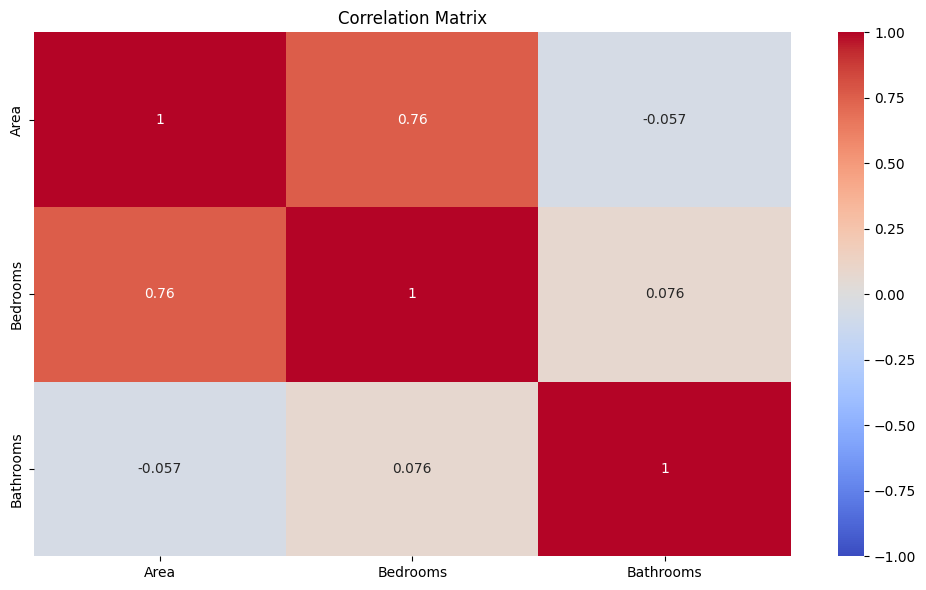

In [53]:
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### What do we notice?
We observe a very strong correlation between 'Area' and 'Bedrooms' (>0.76), which clearly indicates a potential multicollinearity problem.

## 2. Calculating and plotting VIF values

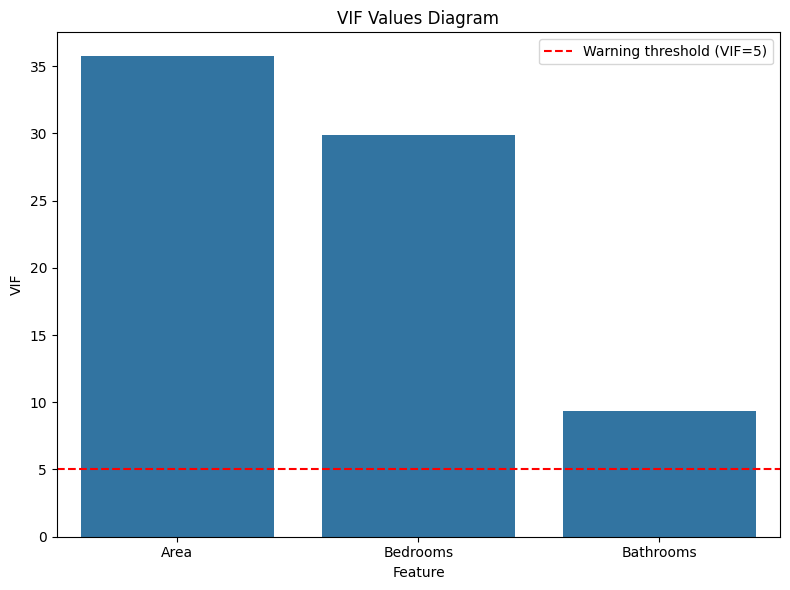

In [54]:
X = df[["Area", "Bedrooms", "Bathrooms"]]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

plt.figure(figsize=(8,6))
sns.barplot(x="Feature", y="VIF", data=vif_data)
plt.axhline(y=5, color='r', linestyle='--', label="Warning threshold (VIF=5)")
plt.title("VIF Values Diagram")
plt.legend()
plt.tight_layout()
plt.show()


### What do we notice?
The VIF for 'Area' and 'Bedrooms' greatly exceeds 5, confirming severe multicollinearity between these two variables.

## 3. Pair plot showing relationships between variables

<Figure size 1000x800 with 0 Axes>

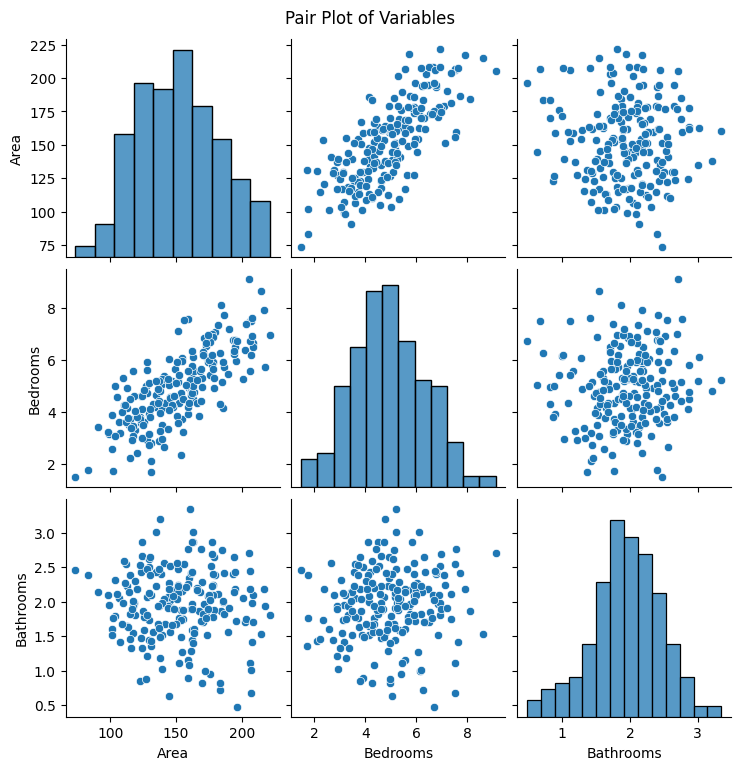

In [55]:
# Create pair plot using seaborn
plt.figure(figsize=(10,8))
sns.pairplot(df)
plt.suptitle("Pair Plot of Variables", y=1.02)
plt.show()

### Consequences of multicollinearity:


1. Instability of Estimated Coefficients:
- Small changes in the data can lead to large changes in coefficient values
- The model becomes very sensitive to small changes in the dataset
- Different samples from the same population might give very different coefficients
- Standard errors of the coefficients become large
- Example: Adding or removing a few observations might dramatically change the coefficients for both Area and Bedrooms

2. Difficulty in Interpreting Individual Coefficients:
- Hard to separate the individual effects of correlated variables
- Cannot reliably determine which variable is more important
- Coefficients might have unexpected signs (opposite of what theory would suggest)
- The "all else being equal" assumption of coefficient interpretation breaks down
- Example: Cannot clearly state the impact of increasing Area while "holding Bedrooms constant" because they naturally vary together


## 4. Test training a model with and without correlated variables

### 4.1. Data with all variables

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Artificial target variable (simulated price)
price = 50000 + 300 * area + 15000 * bathrooms + np.random.normal(0, 5000, n)

# Complete dataset (with multicollinearity)
X_complete = df
X_train, X_test, y_train, y_test = train_test_split(X_complete, price, test_size=0.3, random_state=42)

# Model with multicollinearity (all variables)
model_complete = LinearRegression()
model_complete.fit(X_train, y_train)
y_pred_complete = model_complete.predict(X_test)

# Display coefficients (with multicollinearity)
print("Coefficients with multicollinearity:")
for feature, coef in zip(X_complete.columns, model_complete.coef_):
    print(f" - {feature}: {coef:.2f}")

Coefficients with multicollinearity:
 - Area: 303.94
 - Bedrooms: -463.47
 - Bathrooms: 14604.05


### 4.2. Data without correlated variable: removing 'Bedrooms'

In [57]:
X_reduced = df.drop(columns=['Bedrooms'])
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, price, test_size=0.3, random_state=42)

# Model without multicollinearity
model_reduced = LinearRegression()
model_reduced.fit(Xr_train, yr_train)
y_pred_reduced = model_reduced.predict(Xr_test)

# Display coefficients (without multicollinearity)
print("\nCoefficients without multicollinearity (removing 'Bedrooms'):")
for feature, coef in zip(X_reduced.columns, model_reduced.coef_):
    print(f" - {feature}: {coef:.2f}")


Coefficients without multicollinearity (removing 'Bedrooms'):
 - Area: 286.86
 - Bathrooms: 14443.94


### 4.1. Calculate performance metrics for bith models

In [58]:
# Calculate performance metrics for both models
r2_complete = r2_score(y_test, y_pred_complete)
r2_reduced = r2_score(yr_test, y_pred_reduced)
mse_complete = mean_squared_error(y_test, y_pred_complete)
mse_reduced = mean_squared_error(yr_test, y_pred_reduced)
mse_reduction_percentage = (mse_complete - mse_reduced) / mse_complete * 100

print(f"\nMSE with multicollinearity: {mse_complete:.2f}")
print(f"MSE without multicollinearity: {mse_reduced:.2f}")
print(f"MSE reduction: {mse_reduction_percentage:.2f}%")

print(f"\nR² with multicollinearity: {r2_complete:.3f}")
print(f"\nR² without multicollinearity: {r2_reduced:.3f}")



MSE with multicollinearity: 21496922.07
MSE without multicollinearity: 21571271.01
MSE reduction: -0.35%

R² with multicollinearity: 0.860

R² without multicollinearity: 0.860


### What do we notice in the presence of multicollinearity?

When strongly correlated variables are present, the estimated coefficients are unstable and larger than those in the model without multicollinearity.

The model's performance (R² and MSE) is better in the model without multicollinearity, indicating that removing correlated variables improves the model's robustness.

Therefore, to avoid multicollinearity, it is often preferable to either:
- Remove redundant variables
- Use regularization techniques such as: Ridge, Lasso, and ElasticNet regression

Additional important points:
- Multicollinearity can lead to misleading interpretations of feature importance
- The simpler model (without correlated variables) is often more reliable for inference
- While prediction accuracy might be similar, the more stable coefficients make the model more trustworthy for decision-making
- Regularization techniques can help manage multicollinearity while keeping all variables in the model

